<a href="https://colab.research.google.com/github/ras1364/DetectFakeReviewsUsing-Sentence_BERT/blob/main/FakeReviewDetectionUsingSentenceBertVer3_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code, comments are sent to the Sentence BERT encoder regardless of the number of sentences, and its output is sent to the Dence network.**

In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [3]:
X_test = pd.read_csv("/content/X_test.csv")
X_train = pd.read_csv("/content/X_train.csv")
y_test = pd.read_csv("/content/y_test.csv")
y_train = pd.read_csv("/content/y_train.csv")

In [4]:
max_length = 384
for x in range(0,len(X_train)):
  line = X_train.loc[x].at["text"]
  if max_length < len(line.split()) :
    max_length = len(line.split())

print(max_length)


649


In [5]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

X_train["stemmed_text_data"] = X_train["text"].map(preprocess)
X_test["stemmed_text_data"] = X_test["text"].map(preprocess)

In [6]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2e3df0d7bf01698b275c9cf7ee0be58e6295f5153a43ff2864a86c5b39490a4e
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [7]:
X_train_encoded = sbert_model.encode(X_train["stemmed_text_data"] ,  show_progress_bar=True)
X_test_encoded = sbert_model.encode(X_test["stemmed_text_data"], show_progress_bar=True)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [8]:
print("X_train.shape = " , X_train_encoded.shape, " y_train.shape = ", y_train["deceptive"].shape)
print("X_test.shape = " , X_test_encoded.shape, " y_test.shape = ", y_test["deceptive"].shape)

X_train.shape =  (1200, 384)  y_train.shape =  (1200,)
X_test.shape =  (400, 384)  y_test.shape =  (400,)


In [9]:
y_train

,Unnamed: 0,deceptive
0,620,0
1,923,1
2,916,1
3,608,0
4,938,1
...,...,...
1195,250,1
1196,401,0
1197,515,0
1198,1340,0


In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
# define and fit the final model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ] 
model = Sequential()
model.add(Dense(32, input_shape=(384,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                12320     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,353
Trainable params: 12,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_train_final = y_train.deceptive
model.fit(X_train_encoded,y_train_final, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
19/19 [==============================] - 2s 5ms/step - loss: 0.6853 - accuracy: 0.5767 - precision: 0.5516 - recall: 0.8200
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6850 - precision: 0.6525 - recall: 0.7917
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.7142 - precision: 0.6887 - recall: 0.7817
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.7467 - precision: 0.7578 - recall: 0.7250
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.7325 - precision: 0.7136 - recall: 0.7767
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5622 - accuracy: 0.7692 - precision: 0.7931 - recall: 0.7283
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5380 - accuracy: 0.7775 - precision: 0.7743 - recall: 0.7833
Epoch 8/50
19/19 [==============================] - 0s 

In [13]:
model.evaluate(X_test_encoded, y_test.deceptive)

13/13 [==============================] - 0s 2ms/step - loss: 0.3890 - accuracy: 0.8075 - precision: 0.8398 - recall: 0.7600


[0.3890295922756195,
 0.8075000047683716,
 0.8397790193557739,
 0.7599999904632568]

In [14]:
y_predicted = model.predict(X_test_encoded)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 0s 2ms/step


In [15]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.deceptive, y_predicted)
cm 

array([[171,  29],
       [ 48, 152]])

Text(33.0, 0.5, 'Truth')

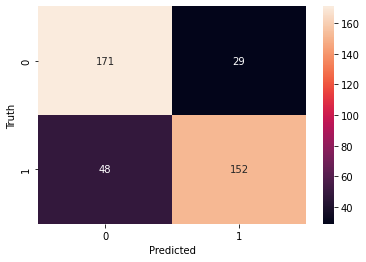

In [17]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [18]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       200
           1       0.84      0.76      0.80       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400

